<h1 align="center">Data Science - Final Project</h1>
<p align="center">
  <a href="https://github.com/cuong091200">
    <img src="https://img.shields.io/badge/18120296-cuong091200-brightgreen.svg">
  </a>
  <a href="https://github.com/viplazylmht">
    <img src="https://img.shields.io/badge/18120339-viplazylmht-brightgreen.svg">
  </a>
  <a href="https://colab.research.google.com/github/cuong091200/DoAnCuoiKy_KHDL/blob/main/ProjectFinal.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg">
  </a>

  <a href="https://github.com/cuong091200/DoAnCuoiKy_KHDL">
    <img src="https://img.shields.io/badge/Github-131313?logo=github&logoColor=white">
  </a>
</p>

<p align="center">Danh sách thành viên</p>

|MSSV|Họ và Tên
|:---|:-
|18120296|Cao Tất Cường
|18120339|Hà Văn Duy

 

## Tổng quan

**COVID-19**

Đây là đại dịch bệnh tryền nhiễm nguy hiểm, phát hiện lần đầu tiên ở Trung Quốc sau đó nhanh chóng lan rộng ra toàn thế giới.  
Người mắc phải virus gây bệnh (SARS-CoV-2) thường sẽ có một khoảng thời gian ủ bệnh từ **2 - 14 ngày**, sau đó xuất hiện triệu chứng, một vài trường hợp có thể diễn tiến rất nhanh trở thành ca bệnh nặng, có thể dẫn đến tử vong.

Thời điểm hiện tại, vacxin vẫn chưa được phân phối rộng rãi và kiểm định kết quả, đồng thời vẫn chưa có thuốc chữa đặc hiệu. Vì vậy, các bệnh nhân cần được chăm sóc y tế hồi sức để cơ thể tự sản sinh ra đề kháng và khỏi bệnh.  
Đây là một dịch bệnh nghiêm trọng, vì vậy việc theo dõi sự tác động của nó với xã hội là điều cực kì cần thiết nhằm đưa ra các chính sách, giải pháp phù hợp để cải thiện tình hình, tiến tới xóa bỏ đại dịch trong tương lai gần.



## Cài đặt và import các thư viện cần thiết

In [1]:
# handle output to /dev/null to ignore text outputs xD
!pip install sodapy > /dev/null

# update sklearn to support set_config attr (see this answer: https://stackoverflow.com/a/62481510)
!pip install --upgrade scikit-learn > /dev/null

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
set_config(display='diagram')
import math
from sodapy import Socrata

import regex as re
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## Thu thập dữ liệu thô


Nguồn cấp dữ liệu: <a href="https://cdc.gov">CDC</a> thông qua API.

<img style="vertical-align:middle" src="https://raw.githubusercontent.com/cuong091200/DoAnCuoiKy_KHDL/main/cdc_logo.svg"></img>

Theo mô tả của API, bộ dữ liệu này chứa danh sách các thông tin bao gồm số ca mắc và số ca tử vong mỗi ngày của các tiểu bang, vùng lãnh thổ và các khu vực pháp lý của Mỹ. Cụ thể hơn, mỗi dòng dữ liệu là số liệu thống kê của một ngày của mỗi bang.  

---

Ta thu thập dữ liệu về và lưu vào `data_df`.

In [3]:
client = Socrata("data.cdc.gov", None)
 
results = client.get("9mfq-cb36", limit=30000)
 
results_df = pd.json_normalize(results)

date = '2021-01-01T00:00:00.000'
results_df = results_df[results_df['submission_date'] <= date]

results_df.to_csv('data.csv', index=False)

In [4]:
data_df = pd.read_csv('data.csv')

## Khám phá dữ liệu thô (đủ để có thể xác định câu hỏi)



In [5]:
data_df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,new_death,pnew_death,created_at,consent_cases,consent_deaths
0,2020-05-04T00:00:00.000,KY,5245,5245.0,0.0,115.0,0.0,261,261.0,0.0,8.0,0.0,2020-05-05T17:25:08.000,Agree,Agree
1,2020-12-08T00:00:00.000,OK,205999,171497.0,34502.0,0.0,0.0,1752,1680.0,72.0,0.0,0.0,2020-12-09T14:45:40.234,Agree,Agree
2,2020-08-21T00:00:00.000,MD,103523,NaN,NaN,624.0,0.0,3685,3546.0,139.0,11.0,1.0,2020-08-22T14:21:09.869,NaN,Agree
3,2020-03-05T00:00:00.000,GA,2,NaN,NaN,-5.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,Agree,Agree
4,2020-02-08T00:00:00.000,WA,1,NaN,NaN,0.0,NaN,0,NaN,NaN,0.0,NaN,2020-03-26T16:22:39.452,NaN,NaN


### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [6]:
data_df.shape

(20760, 15)

### Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?

Quan sát sơ bộ dữ liệu ta thấy mỗi dòng chứa các thông tin về số tổng ca nhiễm, số ca nhiễm mới, sô ca tử vong,... của của 1 bang trong một ngày cụ thể.

### Dữ liệu có các dòng bị lặp không?

In [7]:
data_df.index.duplicated().sum()

0

### Mỗi cột có ý nghĩa gì?

|VARIABLE|DESCRIPTION|TYPE|
|---|----------------|------|
|submission_date|Ngày nộp kết quả|Date & Time|      
|state|Các tiểu bang, vùng lãnh thổ và các khu vực pháp lý của Mỹ|Plain Text|  
|tot_cases|Tổng số lượng ca nhiễm SARS-CoV-2|Number| 
|conf_cases|Tổng số ca nhiễm SARS-CoV-2 đã được xác nhận|Number|
|prob_cases|Tổng số ca có khả năng cao bị nhiễm SARS-CoV-2|Number|
|new_case|Số lượng ca nhiễm SARS-CoV-2|Number|
|pnew_case|Số lượng ca có khả năng bị nhiễm SARS-CoV-2 cao|Number|
|tot_death|Tổng số ca tử vong do SARS-CoV-2|Number|
|conf_death|Tông số ca tử vong được xác nhận do SARS-CoV-2|Number|
|prob_death|Tông số ca tử vong khả năng cao do SARS-CoV-2|Number|
|new_death|Số lượng ca tử vong mới do SARS-CoV-2|Number|
|pnew_death|Số lượng ca tử vong mới khả năng cao do SARS-CoV-2|Number|
|created_at|Ngày tạo dữ liệu|Date & Time|
|consent_cases|Nếu đồng ý thì confirmed and probable cases có dữ liệu, nếu không thì chỉ total cases có dữ liệu|Plain Text|
|consent_deaths|Nếu đồng ý thì confirmed and probable deaths có dữ liệu, nếu không thì chỉ total deaths có dữ liệu|Plain Text|


	


	


	


	




## Đưa ra câu hỏi cần trả lời

Số ca mắc mới trong một ngày bất kì (hợp lệ) là bao nhiêu? Nó phụ thuộc như thế nào vào số ca mắc của những ngày trước đó?



### Ý nghĩa của việc trả lời câu hỏi trên

- Ta sẽ thấy được sự phụ thuộc của số ca mắc mới trong một ngày với số ca mắc của những ngày trước đó.
- Thấy được khả năng và tần suất lây lan của dịch bệnh trên người.
- Đưa ra dự đoán trong tương lai gần nhằm giúp chính phủ và ngành Y tế có thể tăng khả năng y tế dự phòng và triển khai các biện pháp ứng phó phù hợp với tình hình.
- Ước lượng được các làn sóng dịch tiếp theo trong một khu vực.


### Cảm hứng đặt câu hỏi

Cảm hứng để nhóm đặt câu hỏi này bắt nguồn từ thực trạng hiện nay, khi mà diễn biến dịch bệnh vẫn đang rất phức tạp tại nhiều quốc gia trên thế giới, đồng thời với tấm gương sự hành động cứng rắn của chính phủ Việt Nam dựa trên số liệu giúp đạt được kết quả phòng chống dịch tốt như hiện tại.

## Khám phá dữ liệu (để tiền xử lý dữ liệu để phù hợp với bài toán hơn và để biết cách tách các tập)

### Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [8]:
data_df.dtypes

submission_date     object
state               object
tot_cases            int64
conf_cases         float64
prob_cases         float64
new_case           float64
pnew_case          float64
tot_death            int64
conf_death         float64
prob_death         float64
new_death          float64
pnew_death         float64
created_at          object
consent_cases       object
consent_deaths      object
dtype: object

Hiện tại các cột có kiểu dữ liệu  giống với phần mô tả nên không cần xử lý thêm.

### Các cột ouput (`new_case`) và cột `tot_case` (2 cột quan trọng nhất của bộ dữ liệu) phân bố dữ liệu như thế nào?

In [9]:
num_cols = ['tot_cases', 'new_case']
df = data_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,tot_cases,new_case
missing_ratio,0.0,0.0
min,0.0,-33355.0
lower_quartile,145.0,0.0
median,15186.0,199.0
upper_quartile,95093.2,924.0
max,2292568.0,71734.0


Ta thấy cột `tot_cases` có giá trị 0 => nên ta coi các dòng chứa nó là  không hữu ích. Còn `new_case` là cột output nhưng có giá trị bị âm nên ta sẽ tiếp tục khám phá thêm. 

### Vẽ đồ thị boxplot của cột output (`new_case`)

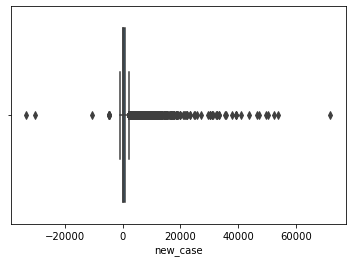

In [10]:
sns.boxplot(x = data_df['new_case'])

`new_case` có giá trị âm là do những ngày trước đó dữ liệu `new_case`  cao so với dữ liệu đúng nên `new_case` bị âm để bù vào những ngày trước đó. Ta thấy có 1 điểm `new_case` xấp xỉ 70000 có khả năng là ngoại lai (outlier).

## Tiền xử lý dữ liệu để phù hợp với bài toán

### Loại bỏ các dòng dữ liệu chắc chắn là nhiễu

Một dòng được coi là dữ liệu nhiễu khi cho tới ngày đó chưa ghi nhận ca mắc nào (`tot_cases = 0`).



In [11]:
data_df1 = data_df[data_df['tot_cases'] > 0]
data_df1.shape

(17119, 15)

### Thêm thuộc tính cho mỗi dòng dữ liệu

Bộ dữ liệu thô phía trên chưa có sự kết nối giữa những ngày liền kề nhau. Vì vậy ta sẽ tiền xử lý một chút để, đối với mỗi dòng dữ liệu, nó sẽ chứa thêm thông tin của số ca mắc mới của `callback_days` ngày liền trước đó. 

Hàm `add_row_df` sẽ làm nhiệm vụ trên: số ca mắc của `i` ngày trước của mỗi dòng dữ liệu sẽ được thêm vào cột `new_case_his_i`. 

Hàm `fix_negative_data` sẽ thực hiện kĩ thuật loại bỏ các dòng dữ liệu có output là âm. Ta sẽ loại bỏ dữ liệu âm này bằng kĩ thuật cộng các đối tượng trước nó. 

In [12]:
def fix_negative_data(new_case_data):
    # accept only pandas series
    if not isinstance(new_case_data, pd.Series):
        raise Exception("Error, please pass a Series to this func")

    result = new_case_data.copy()
    arr = result.values

    for k in range(arr.size - 1, 0, -1):
        total = arr[k]
        count = 1

        while (total < 0) and (k - count >= 0):
            total += arr[k - count]
            count += 1

        if count > 1:
            part = total / count

            for i in range(count):
                arr[k - i] = part

            k -= (count - 1) 

    return result

In [13]:
# number of records will be collected
callback_days = 28

def add_row_df(df):
    df = df.sort_values('submission_date', ascending=True)

    # Validation raw data
    for g in df.groupby('submission_date'):
        if g[1].shape[0] > 1:
            raise Exception("Error, please groupby dataset by date before pass to this func")
    
    # MAGIC
    new_case_data = fix_negative_data(df['new_case'])
    
    df['new_case'] = new_case_data.copy()
    
    l = None

    for j in range(len(new_case_data)):
        if j >= callback_days:
            t = new_case_data.iloc[j - callback_days: j]
            
            # append row
            l = np.r_[l, [np.flip(t)]]
        else:
            t = new_case_data.iloc[0: j + 1]
            fill = np.r_[np.array(['0' for i in range(callback_days - len(t))]), t]

            # append row
            if l is None:
                l = np.array([np.flip(fill)])
            else:
                l = np.r_[l, [np.flip(fill)]]
    
    df2 = pd.DataFrame(l, index=df.index, columns=[f"new_case_his_{i}" for i in range(1, callback_days + 1)])
    df2 = df2.apply(pd.to_numeric, errors='coerce', axis=1)
    return pd.concat([df, df2], axis=1)

Ta sẽ áp dụng phương pháp trên đối với mỗi bang (bằng cách gom nhóm), nhằm đảm bảo dữ liệu nhất quán và chính xác. Kết quả bộ dữ liệu mới sẽ được lưu vào `collected_df`.

In [14]:
collected_df = data_df1.groupby('state').apply(add_row_df).reset_index(level='state', drop=True)

Sau khi làm mượt dữ liệu (xử lý các `new_case` bị âm) ta xem hàng có `new_case` = 70000 đã được làm mượt chưa?

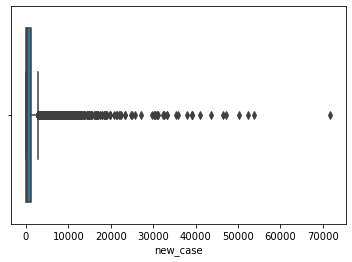

In [15]:
sns.boxplot(x = collected_df['new_case'])

Ta thấy nó vẫn chưa được làm mượt => ta xem đó là outlier.

Xem nó thuộc ngày nào và của bang nào?

In [16]:
index = collected_df['new_case'].nlargest(1).index
collected_df.loc[index, :]

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,...,new_case_his_19,new_case_his_20,new_case_his_21,new_case_his_22,new_case_his_23,new_case_his_24,new_case_his_25,new_case_his_26,new_case_his_27,new_case_his_28
11146,2020-11-01T00:00:00.000,TX,972330,NaN,NaN,71734.0,67475.0,18077,NaN,NaN,...,5289.0,2648.0,2418.0,4230.0,4036.0,4238.0,4121.0,4132.0,3409.0,2884.0


Theo như em tìm hiểu ở một số nguồn khác thì new_case ở ngày 01-11-2020 ở bang Texas không cao đến mức đó. Nên có thể là sai sót do lỗi đánh máy từ sở y tế. Theo CDC thì dữ liệu đến từ sở y tế là dữ liệu cuối cùng.

Ta sẽ tiến hành xóa cột đó đi.

In [17]:
collected_df = collected_df.drop(index)

Đến đây, từ dữ liệu thô, ta đã thu thập đủ dữ liệu (được lưu trong `collected_df`) để có thể khai thác để trả lời câu hỏi.

In [18]:
collected_df.shape

(17118, 43)

In [19]:
collected_df.head()

,submission_date,state,tot_cases,conf_cases,prob_cases,new_case,pnew_case,tot_death,conf_death,prob_death,...,new_case_his_19,new_case_his_20,new_case_his_21,new_case_his_22,new_case_his_23,new_case_his_24,new_case_his_25,new_case_his_26,new_case_his_27,new_case_his_28
18735,2020-03-13T00:00:00.000,AK,1,NaN,NaN,1.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19644,2020-03-14T00:00:00.000,AK,1,NaN,NaN,0.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19279,2020-03-15T00:00:00.000,AK,1,NaN,NaN,0.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17655,2020-03-16T00:00:00.000,AK,1,NaN,NaN,0.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18209,2020-03-17T00:00:00.000,AK,3,NaN,NaN,2.0,NaN,0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Tiền xử lý (tách tập)

Input của bài toán sẽ bao gồm một số cột trong dữ liệu. Output chính là cột `new_case`. 

In [20]:
sorted_df = collected_df.sort_values('submission_date', ascending=True)
X_df = sorted_df.drop('new_case', axis=1)
y_sr = sorted_df['new_case']

Tách theo tỉ lệ: 70% 15% 15% lần lượt cho bộ train, bộ validation, bộ test.

In [21]:
# tách bộ (train, validation) và bộ test
train_X_df, test_X_df, train_y_sr, test_y_sr = train_test_split(X_df, y_sr, train_size = 0.85, 
                                                             shuffle=False, random_state=0)

Tách bộ train và bộ validation.

In [22]:
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(train_X_df, train_y_sr, train_size=(7/8.5), 
                                                              random_state=0)

In [23]:
train_X_df.shape

(11982, 42)

In [24]:
val_X_df.shape

(2568, 42)

In [25]:
test_X_df.shape

(2568, 42)

## Khám phá dữ liệu (tập huấn luyện)

### Mỗi cột input hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [26]:
train_X_df.dtypes

submission_date     object
state               object
tot_cases            int64
conf_cases         float64
prob_cases         float64
pnew_case          float64
tot_death            int64
conf_death         float64
prob_death         float64
new_death          float64
pnew_death         float64
created_at          object
consent_cases       object
consent_deaths      object
new_case_his_1     float64
new_case_his_2     float64
new_case_his_3     float64
new_case_his_4     float64
new_case_his_5     float64
new_case_his_6     float64
new_case_his_7     float64
new_case_his_8     float64
new_case_his_9     float64
new_case_his_10    float64
new_case_his_11    float64
new_case_his_12    float64
new_case_his_13    float64
new_case_his_14    float64
new_case_his_15    float64
new_case_his_16    float64
new_case_his_17    float64
new_case_his_18    float64
new_case_his_19    float64
new_case_his_20    float64
new_case_his_21    float64
new_case_his_22    float64
new_case_his_23    float64
n

Hiện tại các cột có kiểu dữ liệu hợp lý, không có vấn đề gì.

### Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?

In [27]:
whitelist = ['submission_date', 'state', 'created_at','consent_cases','consent_deaths']
num_cols = list(set(train_X_df.columns) - set(whitelist))
df = train_X_df[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,new_case_his_9,pnew_case,new_case_his_1,new_case_his_25,new_case_his_22,new_case_his_15,new_case_his_21,conf_death,new_case_his_20,pnew_death,...,new_case_his_11,prob_death,conf_cases,prob_cases,new_case_his_4,new_case_his_3,new_case_his_12,new_case_his_17,new_case_his_10,new_case_his_14
missing_ratio,0.0,16.5,0.0,0.0,0.0,0.0,0.0,50.7,0.0,17.1,...,0.0,50.7,53.3,53.3,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,-33864.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-837.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lower_quartile,29.0,0.0,41.0,9.0,12.0,20.0,13.0,303.0,14.0,0.0,...,25.0,0.0,8539.0,8.0,37.0,38.0,24.0,17.0,27.0,21.0
median,253.0,0.0,291.0,184.0,194.0,226.0,201.0,1303.0,203.0,0.0,...,245.0,36.0,38171.0,1078.0,279.0,282.0,241.0,219.0,248.5,228.5
upper_quartile,792.0,25.0,859.8,663.8,681.0,736.0,692.0,3551.8,696.0,0.0,...,776.0,205.8,107271.0,4764.5,833.0,837.0,764.0,727.8,787.8,744.0
max,71734.0,5014.0,71734.0,17820.0,17820.0,71734.0,17820.0,19505.0,17820.0,4059.0,...,71734.0,5395.0,597849.0,39752.0,71734.0,71734.0,71734.0,15135.0,71734.0,71734.0


Ta thấy những thuộc tính `prob_cases`, `conf_cases` là những thuộc tính quan trọng nhưng có tỷ lệ mising value lớn ta sẽ xử lý ở phần tiền xử lý cho tập huấn luyện. Còn `pnew_case`, `new_death`, `pnew_death` `conf_death`, `prob_death` có tỷ lệ mising value lớn nhưng nó không có ích cho mô hình nên ta sẽ bỏ các thuộc tính đó đi.

## Tiền xử lý tập huấn luyện





### Các class cần thiết cho pipeline
- Loại bỏ các thuộc tính dự đoán như `pnew_case`, `pnew_death`
- Loại bỏ các thuộc tính không có ích cho việc huấn luyện mô hình như `submission_date`, `state`, `conf_death`, `prob_death`, `created_at`, `consent_cases`, `consent_deaths`

- Dùng tham số `callback_days` để quy định chỉ lấy số ngày gần nhất của ngày hiện tại.

- Hàm `mix_data` dùng để fill lại các giá trị của cột `conf_cases` bằng giá trị tương ứng của cột `tot_cases` nếu nó bị thiếu.
- Tạo thêm cột `total_new_case_his` là tổng của các `new_case_his_i` và xóa các cột `new_case_his_i` để tránh trường hợp quá nhiều thuộc tính dễ dẫn đến overfitting.

In [28]:
class ColAdderDropper(BaseEstimator, TransformerMixin):
    def __init__(self, callback_days=14):
        self.callback_days = callback_days

    def fit(self, X_df, y=None):
        return self
    
    def mix_data(self, row):
        tot_cases = row.loc['tot_cases']
        if row.isnull().loc['conf_cases']:
            row.loc['conf_cases'] = tot_cases            

        return row

    def transform(self, X_df, y=None):

        # drop unsue attr
        df = X_df.drop(['pnew_case', 'pnew_death', 'submission_date', 'state', 'conf_death', 'prob_death', 'created_at',
                        'consent_cases', 'consent_deaths'], axis=1, errors = 'ignore')

        # regex to match first number in any text
        matcher = re.compile(r'.*?(\d+)')
        
        columns_sr = df.columns.str.extract(r'(.*?\d+)', expand=False).dropna().to_series()
        list_drop_his = columns_sr.transform(lambda x: x if int(matcher.findall(x)[0]) > self.callback_days else np.nan).dropna().values.tolist()
        if len(list_drop_his) > 0:
            df = df.drop(list_drop_his, axis=1)
            
        # get  sum new_case_his   
        df['total_new_case_his'] = df.iloc[:, 5:].sum(axis=1)
        df = df.drop(df.columns[5:-1],axis=1)

        return df.transform(self.mix_data, axis=1)


In [29]:
# TEST
estimator = ColAdderDropper(callback_days=5)
estimator.fit(train_X_df)

ColAdderDropper(callback_days=5)

In [30]:
# TEST
estimator.transform(train_X_df).head()

,tot_cases,conf_cases,prob_cases,tot_death,new_death,total_new_case_his
5243,80695.0,77323.0,3372.0,2399.0,84.0,3757.0
335,741.0,559.0,182.0,7.0,0.0,54.0
3784,1834.0,1834.0,NaN,13.0,6.0,1050.0
14681,220819.0,216199.0,4620.0,23323.0,40.0,1564.0
16890,242043.0,242043.0,NaN,3066.0,67.0,35154.0


### Xây dựng pipeline



+ Dữ liệu được đi qua ColAdderDropper để xóa các thuộc tính không cần thiết, thêm thuộc tính `total_new_case_his` và fill mising value cho thuộc tính `conf_cases`.
+ Các thuộc tính sẽ được fill mising value bằng `mean` nhằm đảm bảo không còn nơi nào bị thiếu dữ liệu kể cả trên bộ test mới.
+ Cuối cùng, khi tất cả các cột đã được điền giá trị thiếu và đã có dạng số, ta sẽ tiến hành chuẩn hóa bằng  StandardScaler.

In [31]:
preprocess_pipeline =  make_pipeline(ColAdderDropper(), SimpleImputer(strategy='mean'), StandardScaler())

## Mô hình hóa

### Tìm mô hình tốt nhất

#### Thử nhiệm 1: Mô hình Linear regression

In [32]:
 pipe_line = make_pipeline(preprocess_pipeline,
            LinearRegression())

In [33]:
# Thử nghiệm với các giá trị khác nhau của siêu tham số callback_days
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
callback_days_s = [6, 8, 12, 16, 20, 24, 28]
best_val_err = float('inf'); best_callback_days = None
for callback_days in callback_days_s:
    print(f"callback_days={callback_days}...", end="\t")
    pipe_line.set_params(pipeline__coladderdropper__callback_days=callback_days)

    pipe_line.fit(train_X_df, train_y_sr)
        
    train_err = (1 - r2_score(train_y_sr, pipe_line.predict(train_X_df))) * 100
    val_err = (1 - r2_score(val_y_sr, pipe_line.predict(val_X_df))) * 100
        
    train_errs.append(train_err)
    val_errs.append(val_err)
        
    if val_err < best_val_err:
        best_val_err = val_err 
        best_callback_days = callback_days        

    print(f"train_err: {train_err}\t val_err: {val_err}")              
'Finish!'

callback_days=6...	train_err: 16.067133185308403	 val_err: 16.30693057746384
callback_days=8...	train_err: 15.13752570241288	 val_err: 16.678218714128022
callback_days=12...	train_err: 16.34641948487301	 val_err: 16.9554786574056
callback_days=16...	train_err: 17.925649255866528	 val_err: 17.739452979335944
callback_days=20...	train_err: 20.05685430605818	 val_err: 20.351698217972658
callback_days=24...	train_err: 22.27862985318614	 val_err: 22.80246902290711
callback_days=28...	train_err: 24.698992120999463	 val_err: 25.383069227029676


'Finish!'

In [34]:
print(best_callback_days)

6


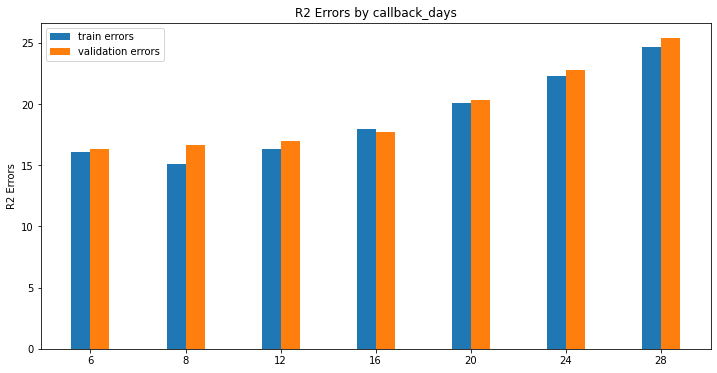

In [35]:
x = np.arange(len(callback_days_s))  # the label locations
width = 0.2  # the width of the bars


fig, ax = plt.subplots()
fig.set_size_inches(12, 6, forward=True)
rects1 = ax.bar(x - width/2, train_errs, width, label='train errors')
rects2 = ax.bar(x + width/2, val_errs, width, label='validation errors')

ax.set_ylabel('R2 Errors')
ax.set_title('R2 Errors by callback_days')
ax.set_xticks(x)
ax.set_xticklabels(callback_days_s)
ax.legend()

Ta thấy độ lỗi trên tập train cũng xấp xỉ với độ lỗi trên tập validation điều đó chứng tỏ mô hình fit khá tốt trên cả 2 tập dữ liệu. Khi tăng `callback_day` thì độ lỗi trên tập train và tập validtion đều tăng. Ta có callback_day = 6 là siêu tham số tốt nhất.

In [36]:
pipe_line.set_params(pipeline__coladderdropper__callback_days=best_callback_days)
 
pipe_line.fit(pd.concat([train_X_df, val_X_df]), pd.concat([train_y_sr, val_y_sr]))

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(callback_days=6)),
                                 ('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())])),
                ('linearregression', LinearRegression())])

Đánh giá độ lỗi trên bộ test

In [37]:
(1 - r2_score(test_y_sr, pipe_line.predict(test_X_df))) * 100

18.110692536607466

#### Thử nhiệm 2: Mô hình MLP

In [38]:
pipe_line1 = make_pipeline(preprocess_pipeline,
            MLPRegressor(hidden_layer_sizes=(15,), activation='relu', solver='adam', max_iter=6000, random_state=0))


+ Chọn dùng `activation=relu` do đây là hàm được sử dụng phổ biến. Đối với các giá trị đầu vào âm (không phải input) thì kết quả là 0, điều đó có nghĩa là neuron không được kích hoạt. Vì chỉ một neuron nhất định được kích hoạt nên hàm ReLU hiệu quả hơn nhiều về mặt tính toán khi so sánh với hàm logistic và tanh.
+ Chọn `solver=adam` vì theo sklean mô tả thì adam hoạt động khá tốt trên các tập dữ liệu tương đối lớn (với hàng nghìn mẫu đào tạo trở lên) cả về thời gian đào tạo và validation score.

In [39]:
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs1 = []
val_errs1 = []
alphas = [0.1, 10, 1000, 10000, 100000]
callback_days_s = [6, 8, 12, 16, 20, 24, 28]
best_val_err1 = float('inf'); best_alpha = None; best_callback_days1 = None
for alpha in alphas:
    for callback_days in callback_days_s:
        
        print(f"Processing alpha={alpha}\tcallback_days={callback_days}...", end="\t")
        pipe_line1.set_params(pipeline__coladderdropper__callback_days=callback_days, mlpregressor__alpha=alpha)

        pipe_line1.fit(train_X_df, train_y_sr)
        
        train_err = (1 - r2_score(train_y_sr, pipe_line1.predict(train_X_df))) * 100
        val_err = (1 - r2_score(val_y_sr, pipe_line1.predict(val_X_df))) * 100
        
        train_errs1.append(train_err)
        val_errs1.append(val_err)
        
        if val_err < best_val_err1:
            best_val_err1 = val_err 
            best_alpha = alpha
            best_callback_days1 = callback_days        

        print(f"train_err: {train_err}\t val_err: {val_err}")  
'Finish!'

Processing alpha=0.1	callback_days=6...	train_err: 15.966204868911337	 val_err: 16.287283885157567
Processing alpha=0.1	callback_days=8...	train_err: 15.10471857392699	 val_err: 16.70104908860175
Processing alpha=0.1	callback_days=12...	train_err: 15.840017080930945	 val_err: 16.453107827907033
Processing alpha=0.1	callback_days=16...	train_err: 17.077670569738757	 val_err: 17.019797574509553
Processing alpha=0.1	callback_days=20...	train_err: 18.97494849765988	 val_err: 19.292534112553138
Processing alpha=0.1	callback_days=24...	train_err: 20.925796757565895	 val_err: 21.538592018041847
Processing alpha=0.1	callback_days=28...	train_err: 22.86085197276244	 val_err: 23.764714678289177
Processing alpha=10	callback_days=6...	train_err: 15.965546611024584	 val_err: 16.289153328806847
Processing alpha=10	callback_days=8...	train_err: 15.104995916852282	 val_err: 16.70103998626772
Processing alpha=10	callback_days=12...	train_err: 15.84009513108844	 val_err: 16.454794357149517
Processing al

'Finish!'

In [40]:
print(best_alpha) 
print(best_callback_days1)

0.1
6


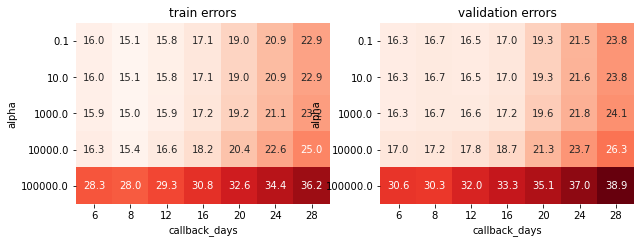

In [41]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs1).reshape(len(alphas), -1),
                             index=alphas, columns=callback_days_s)
val_errs_df = pd.DataFrame(data=np.array(val_errs1).reshape(len(alphas), -1), 
                           index=alphas, columns=callback_days_s)
min_err = min(min(train_errs1), min(val_errs1))
max_err = max(max(train_errs1), max(val_errs1))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('callback_days'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('callback_days'); plt.ylabel('alpha');

Nhận xét:
+ Ta thấy độ lỗi trên tập train cũng xấp xỉ với độ lỗi trên tập validation điều đó chứng tỏ mô hình fit khá tốt trên cả 2 tập dữ liệu.
+ Khi alpha tăng dần, tức sự ảnh hưởng của regularization tăng lên thì độ lỗi trên tập train cũng tăng theo do mô hình bị kìm hãm việc học khi có alpha lớn. Khi alpha = 0,1 thì độ lỗi trên tập validation là thấp nhất.
+ Khi callback_days tăng dần thì độ lỗi trên cả tập train và tập validation đều tăng. Khi callback_days có giá trị 6 thì độ lỗi tập validation là thấp nhất.

In [42]:
pipe_line1.set_params(pipeline__coladderdropper__callback_days=best_callback_days1, mlpregressor__alpha=best_alpha)
#pipe_line1.set_params(pipeline__coladderdropper__callback_days=10, mlpregressor__alpha=4)
 
pipe_line1.fit(pd.concat([train_X_df, val_X_df]), pd.concat([train_y_sr, val_y_sr]))

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('coladderdropper',
                                  ColAdderDropper(callback_days=6)),
                                 ('simpleimputer', SimpleImputer()),
                                 ('standardscaler', StandardScaler())])),
                ('mlpregressor',
                 MLPRegressor(alpha=0.1, hidden_layer_sizes=(15,),
                              max_iter=6000, random_state=0))])

Đánh giá độ lỗi trên bộ test

In [43]:
(1 - r2_score(test_y_sr, pipe_line1.predict(test_X_df))) * 100

18.05205510242591

### Đánh giá mô hình tìm được

Dự vào kết quả độ lỗi trên tập validation và tập test  ta thấy rằng mô hình MLP regression hoạt động tốt hơn mô hình Linear regression với các siêu tham số như sau: 

hidden_layer_sizes=(15,), activation='relu', solver='adam', max_iter=3000

Mô hình chỉ ra sử dụng callback_days = 6 là tốt nhất

## Quan sát kết quả và dự đoán tương lai (bonus) 

Vẽ biểu đồ thể hiện độ chính xác của kết quả dự đoán trên bộ test (màu cam) và kết quả đúng của bộ test (màu xanh).

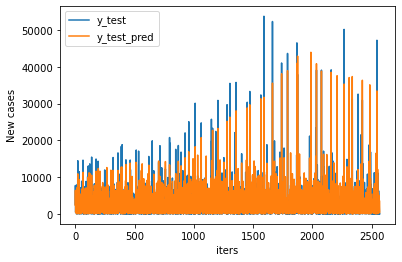

In [44]:
plt.plot(test_y_sr.reset_index(drop=True))
plt.plot(pipe_line1.predict(test_X_df))
plt.legend(['y_test', 'y_test_pred'])
plt.ylabel('New cases')
plt.xlabel('iters');

Nhận xét: Biều đồ trên chỉ ra mô hình đã cố gắng làm giảm sự biến thiên của kết quả bộ test (các đường màu cam có độ lớn chênh lệch ít hơn màu xanh).

---
### Vẽ biểu đồ kết quả dự đoán của mô hình trên toàn USA.

Tạo bộ dữ liệu của USA cho việc test model

In [45]:
usa_collected_df = add_row_df(data_df.groupby('submission_date').sum())

In [46]:
usa_collected_df.shape

(346, 38)

Bộ dữ liệu có 349 dòng tương đương với 349 ngày

Tiến hành tách tập dữ liệu Mỹ

In [47]:
usa_X_df = usa_collected_df.drop('new_case', axis=1)
usa_y_sr = usa_collected_df['new_case']

Đánh giá độ lỗi trên bộ dữ liệu của cả nước Mỹ

In [48]:
(1 - r2_score(usa_y_sr, pipe_line1.predict(usa_X_df))) * 100

5.124198650583988

Vẽ biểu đồ thể hiện độ chính xác của kết quả dự đoán trên bộ test (màu cam) và kết quả đúng của bộ test (màu xanh).

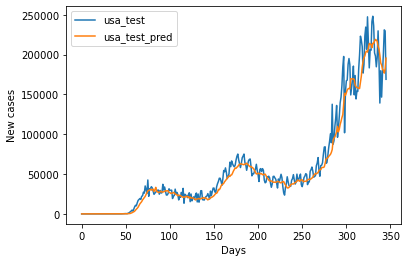

In [49]:
plt.plot(usa_y_sr.reset_index(drop=True))
plt.plot(pipe_line1.predict(usa_X_df))
plt.legend(['usa_test', 'usa_test_pred'])
plt.ylabel('New cases')
plt.xlabel('Days');

Nhận xét: Biểu đồ này ghi nhận số ca mắc của khu vực cả nước Mỹ biến thiên theo thời gian. model dự đoán khá chính xác từ ngày đầu tiên đến những ngày có trong tập train và tập validation. Còn những ngày trong tập test thì model chưa fit tốt (có thể nhìn thấy đoạn cuối của đồ thị).

### Dự đoán tương lai

In [50]:
def GeneratorData(df): 
  temp= df.copy()
  index = df.index[0]
  for i in range(df.shape[1] - 1, 10,-1):
      df.iat[0, i] = df.iloc[0, i-1]
      
  df.at[index, 'new_case_his_1'] = df.loc[index,'new_case']
  df.at[index, 'tot_cases'] += df.loc[index,'new_case']
  
  # tot_death mac ke no NaN di
  df.at[index, 'tot_death'] += 0 if math.isnan(df.loc[index, 'new_death']) else df.loc[index, 'new_death']
  
  #df.at[index, 'conf_cases'] = df.at[index, 'prob_cases'] = df.at[index, 'new_death'] = np.NaN
  return df

In [51]:
date_df = GeneratorData(usa_collected_df.tail(1).copy())
y_pred = np.array([])
for i in range(20):
    y_pred = np.append(y_pred, pipe_line1.predict(date_df.drop('new_case',axis=1)))
    date_df.at[date_df.index[0], 'new_case'] = y_pred[-1]
    date_df = GeneratorData(date_df)

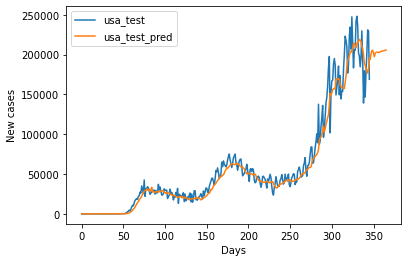

In [52]:
plt.plot(usa_y_sr.reset_index(drop=True))
plt.plot(np.concatenate([pipe_line1.predict(usa_X_df),y_pred]))
plt.legend(['usa_test', 'usa_test_pred'])
plt.ylabel('New cases')
plt.xlabel('Days');